In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

In [2]:
def Elementos(df):
    for column in df.columns:
        lista=df[column].unique()
        print(column + ' tiene ' + str(len(lista)) +' elementos')
        if len(lista)<2 or len(lista)>1000:
            continue
        counts=pd.DataFrame()
        for elemento in lista:
            counts.loc[elemento,'Cantidad']=sum(df[column]==elemento)
        counts.plot.bar()
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.title(f'Element Counts in {column}')
        plt.show()

In [3]:
def create_dummy_variables(data):
    categorical_columns = data.select_dtypes(include='object').columns.tolist()
    new_data = data.copy()
    for column in categorical_columns:
        dummies = pd.get_dummies(new_data[column], prefix=column, drop_first=True)
        new_data = pd.concat([new_data, dummies], axis=1)
    new_data = new_data.drop(categorical_columns, axis=1)
    return new_data

In [4]:
def indicadores(Ytest,Ypred):
    mean_error=(Ytest-Ypred).abs().mean()
    print("Mean Error:", mean_error)
    mse = mean_squared_error(Ytest,Ypred)
    print("Mean Squared Error:", mse)
    r2 = r2_score(Ytest, Ypred)
    print("R-squared: ", r2)
    m = confusion_matrix(Ytest,Ypred)
    print('confusion:')
    print(m)
    Aux=pd.DataFrame()
    Aux['Y_Test']=Ytest
    Aux['Y_Pred']=Ypred
    Aux=Aux.sort_values(by=['Y_Test','Y_Pred'],ascending=True).reset_index().drop(columns=['index'])
    Aux.plot(y=['Y_Test','Y_Pred'], kind='line',alpha=0.5)
    return m

# Leo la base de datos

In [5]:
BD=pd.read_csv('dataset_SCL.csv')

/tmp/ipykernel_72925/433755694.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  BD=pd.read_csv('dataset_SCL.csv')


## Existe un warning, se debe a que hay números y letras en las columnas 1 y 6, correspondiente a números de vuelos, lo que es consistente. por lo que fijare estos elementos como strings.

In [6]:
BD=pd.read_csv('dataset_SCL.csv',dtype={'Vlo-I': str, 'Vlo-O': str})
BD

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


# Pregunta 1: 
## ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?


Para ver como se distribuyen los datos, genero gráficos las distintas cantidades de distintos elementos.
Mediante la funcion Elementos definida arriba. 

Es posible concluir lo siguiente:
-En la base hay elementos que solo tienen un valor, por lo que no nos sirven para realizar predicciones. 
-Los datos asociados a las fechas con detalle son muchos, pero se agrupan sensatamente en categorías, de día, mes y año.
-Se pueden observar algunas tendencias, como las aerolíneas más utilizadas o los destinos más comunes. 


Fecha-I tiene 53252 elementos
Vlo-I tiene 584 elementos


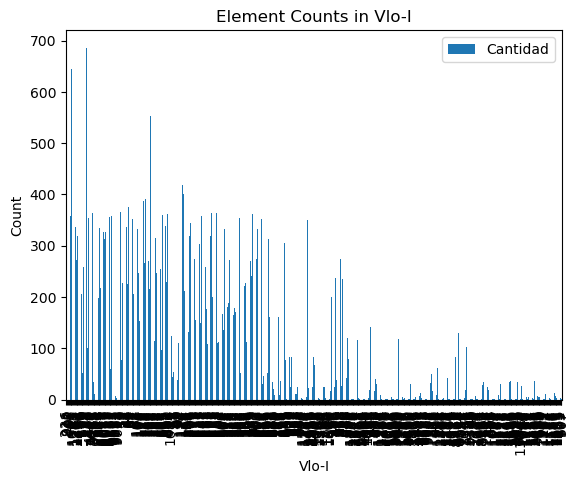

Ori-I tiene 1 elementos
Des-I tiene 64 elementos


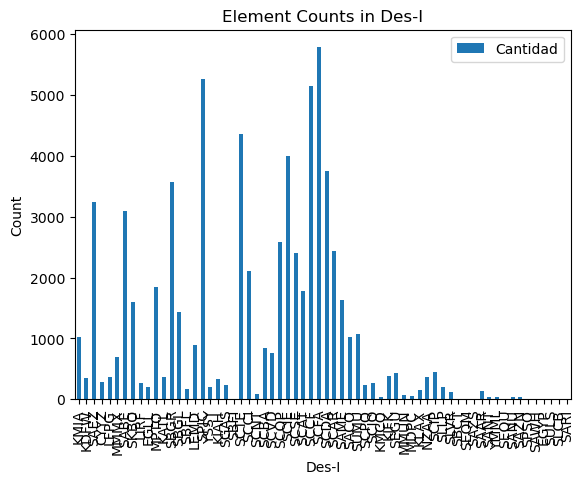

Emp-I tiene 30 elementos


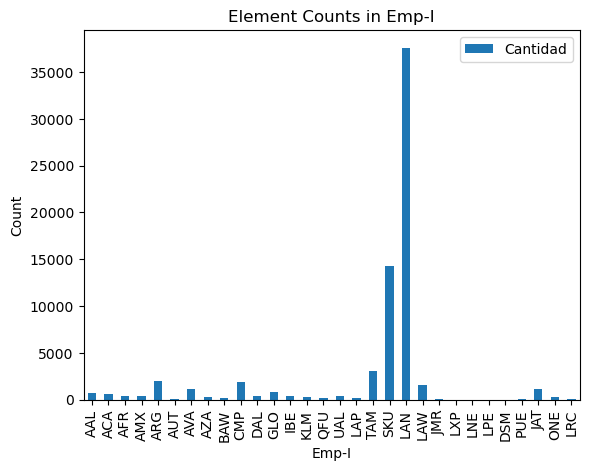

Fecha-O tiene 62774 elementos
Vlo-O tiene 862 elementos


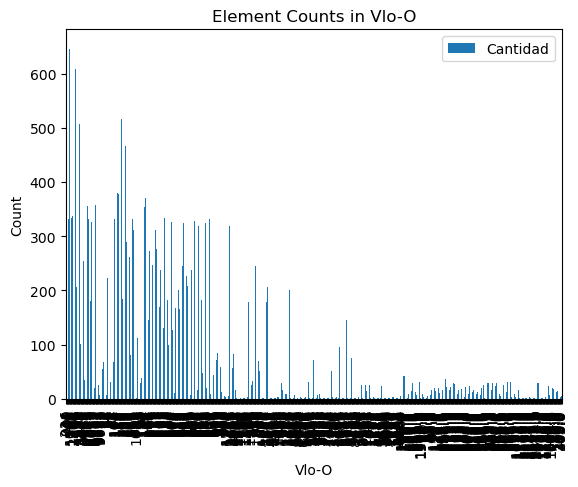

Ori-O tiene 1 elementos
Des-O tiene 63 elementos


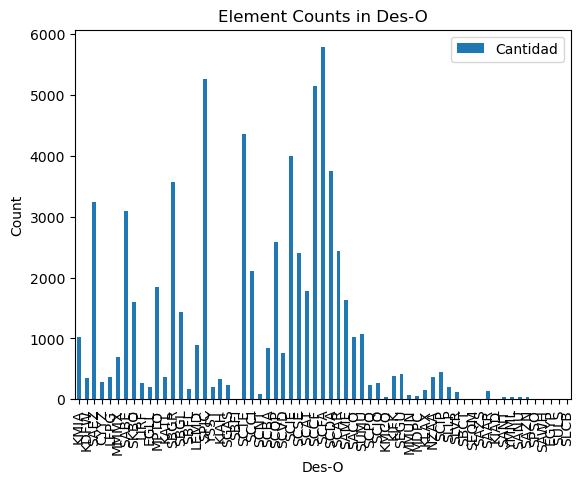

Emp-O tiene 32 elementos


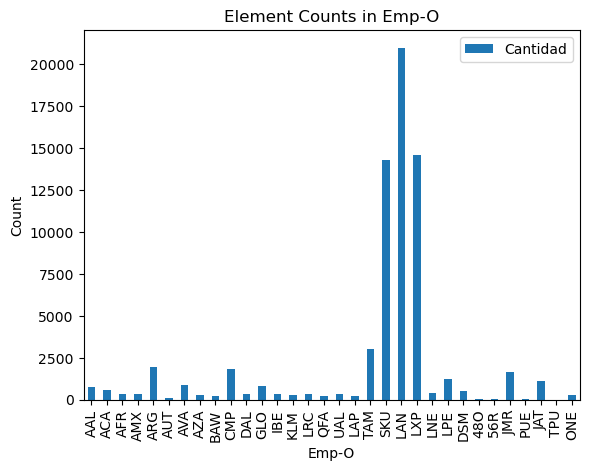

DIA tiene 31 elementos


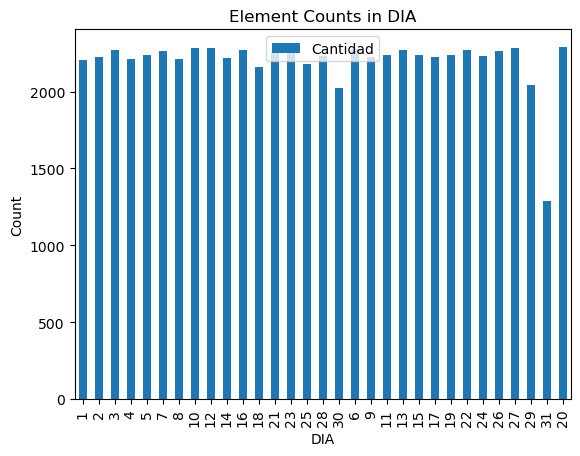

MES tiene 12 elementos


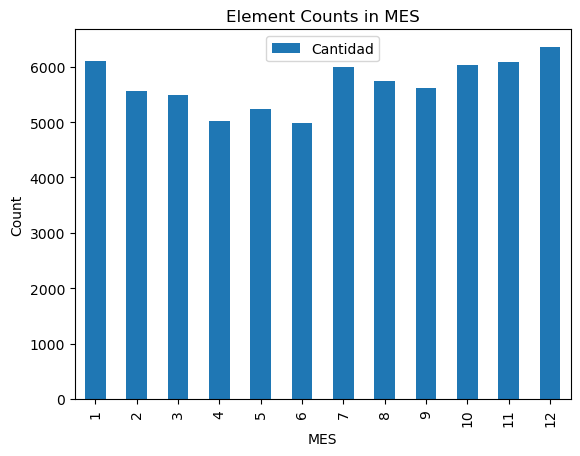

AÑO tiene 2 elementos


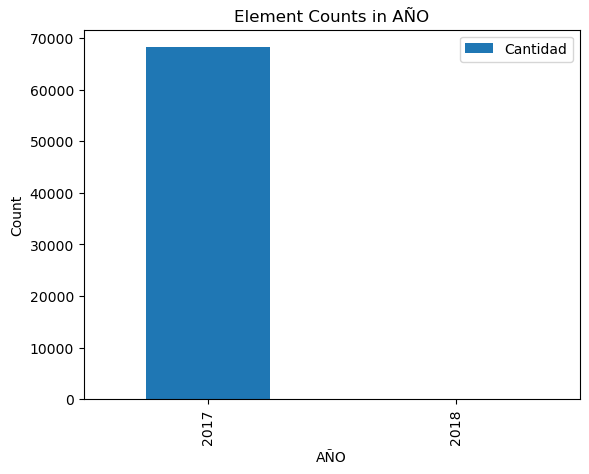

DIANOM tiene 7 elementos


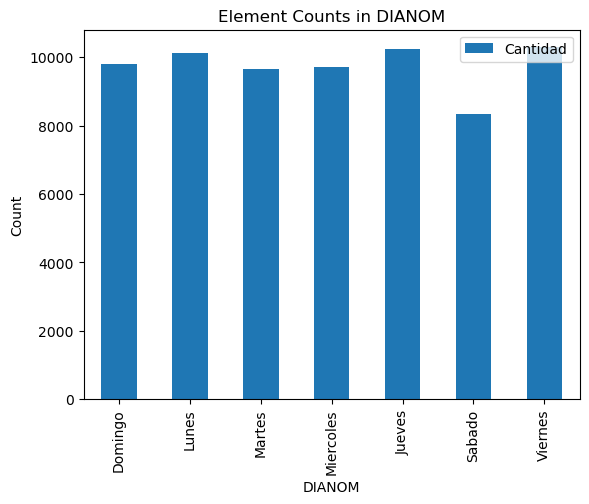

TIPOVUELO tiene 2 elementos


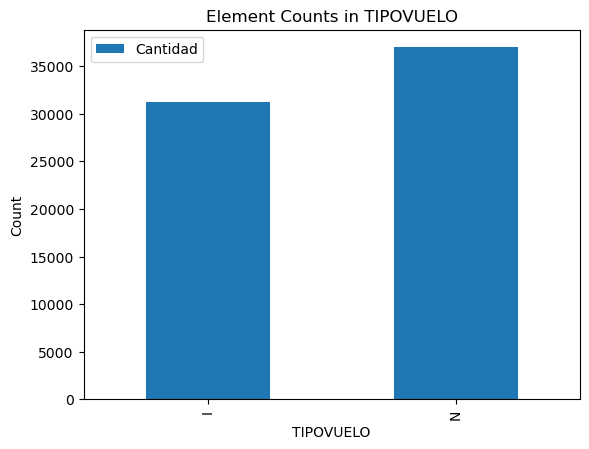

OPERA tiene 23 elementos


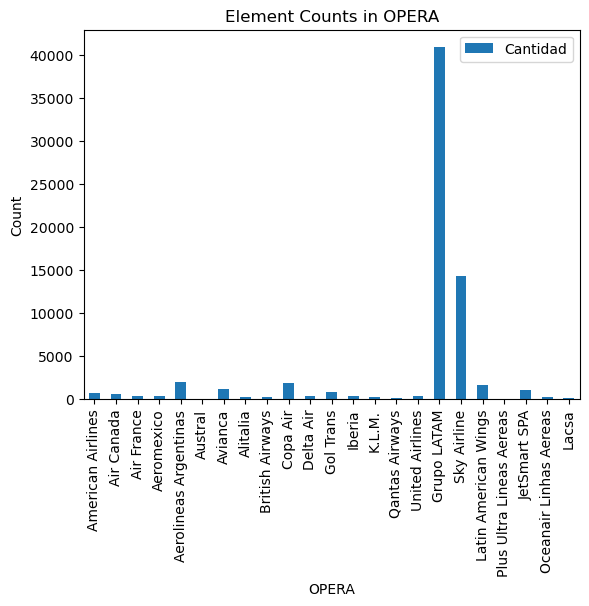

SIGLAORI tiene 1 elementos
SIGLADES tiene 62 elementos


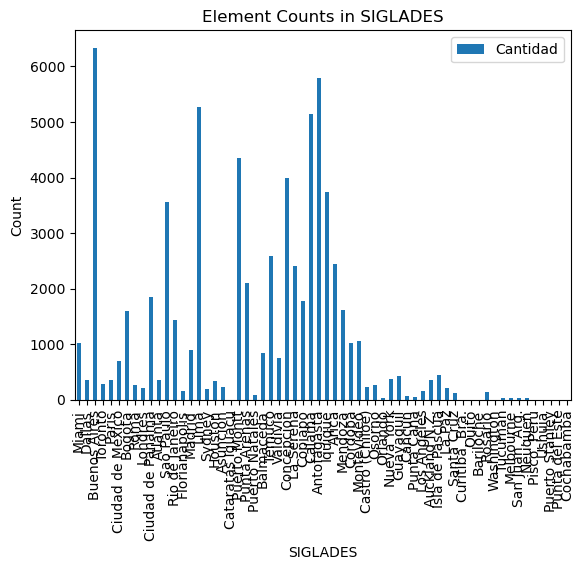

In [7]:
Elementos(BD)

# Pregunta 2:
## Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv:
a. Temporada alta: la temporada alta se considera si Fecha-I está entre 15 Diciembre y 3 Marzo, o 15 Julio y 31 Julio, o 11 Septiembre y 30 Septiembre.  
b. Diferencia en minutos : diferencia en minutos entre Fecha-O y Fecha-I .  
c. Atraso menor: atrasos menores son aquellos donde el tiempo total de atraso es más de 0 minutos y menos de 15 minutos.  
d. Periodo día: donde los periodos del día se consideran como mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I.






# a.-

In [8]:
BD['Temporada_alta']=False

In [9]:
BD['Fecha-I']=pd.to_datetime(BD['Fecha-I'])

In [10]:
start_date = datetime.datetime(2017, 12, 15)
end_date = datetime.datetime(2018, 3, 16)
BD.loc[(BD['Fecha-I'] >= start_date) & (BD['Fecha-I'] < end_date),'Temporada_alta'] = True 
start_date = datetime.datetime(2017, 7, 15)
end_date = datetime.datetime(2017, 8, 1)
BD.loc[(BD['Fecha-I'] >= start_date) & (BD['Fecha-I'] < end_date),'Temporada_alta'] = True 
start_date = datetime.datetime(2017, 9, 11)
end_date = datetime.datetime(2018, 10, 1)
BD.loc[(BD['Fecha-I'] >= start_date) & (BD['Fecha-I'] < end_date),'Temporada_alta'] = True 

# b.- 

In [11]:
BD['Fecha-I']=pd.to_datetime(BD['Fecha-I'])
BD['Fecha-O']=pd.to_datetime(BD['Fecha-O'])

In [12]:
BD['Diferencia_en_minutos'] = (BD['Fecha-O'] - BD['Fecha-I']).dt.total_seconds() / 60

# c.-

In [13]:
BD['Atraso_menor']=(BD['Diferencia_en_minutos']>0)&(BD['Diferencia_en_minutos']<15)

# d.-

In [14]:
BD['Periodo_día'] = pd.NA
BD.loc[(BD['Fecha-I'].dt.hour >= 5) & (BD['Fecha-I'].dt.hour < 12), 'Periodo_día'] = 'Mañana'
BD.loc[(BD['Fecha-I'].dt.hour >= 12) & (BD['Fecha-I'].dt.hour < 19), 'Periodo_día'] = 'Tarde'
BD.loc[(BD['Fecha-I'].dt.hour >= 19) | (BD['Fecha-I'].dt.hour < 5), 'Periodo_día'] = 'Noche'

# Exporto a synthetic_features.csv:

In [15]:
BD[['Temporada_alta','Diferencia_en_minutos','Atraso_menor','Periodo_día']].to_csv('synthetic_features.csv')

# Pregunta 3:
## Entrena uno o varios modelos usando los algoritmos que prefieras para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.

En primera instancia defino una columna que indica existencia o no de atraso:

In [16]:
BD['Atraso']=BD['Diferencia_en_minutos']>0

A continuación eliminare columnas que no presentan utilidad, es decir las contienen menos de 2 valores únicos y las que contienen fechas con alta precisión, dado que su información se encuentra capturada en otras variables. 
Para no perder la información, generare nueva base de datos. 

In [17]:
BD2=BD.copy()

In [18]:
BD2=BD2.drop(columns=['Fecha-I','Ori-I','Fecha-O','Ori-O','SIGLAORI'])

También elimino variables Diferencia_en_minutos, Atraso_menor y los valores "-O" restantes, debido a que asumiré que desconozco la información especifica de operación del vuelo para la predicción, por lo que es información no útil. 

In [19]:
BD2=BD2.drop(columns=['Diferencia_en_minutos','Atraso_menor','Vlo-O','Des-O','Emp-O'])

A continuación genero variables dummies para las variables categóricas correspondientes, utilizo la función definida arriba:

In [20]:
BD2=create_dummy_variables(BD2)

In [21]:
BD2

,DIA,MES,AÑO,Temporada_alta,Atraso,Vlo-I_10,Vlo-I_100,Vlo-I_1003,Vlo-I_1004,Vlo-I_1005,...,SIGLADES_Sao Paulo,SIGLADES_Sydney,SIGLADES_Temuco,SIGLADES_Toronto,SIGLADES_Tucuman,SIGLADES_Ushuia,SIGLADES_Valdivia,SIGLADES_Washington,Periodo_día_Noche,Periodo_día_Tarde
0,1,1,2017,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,1,2017,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,2017,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,1,2017,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,1,2017,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,22,12,2017,True,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68202,25,12,2017,True,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68203,27,12,2017,True,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68204,29,12,2017,True,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Fijo variables no numéricas como numéricas 

In [22]:
BD2['Temporada_alta']=BD2['Temporada_alta']+0
BD2['Atraso']=BD2['Atraso']+0

Separare las variables entre salidas (Atraso) y entradas, el resto de la base de datos BD2.

In [23]:
Y=BD2[['Atraso']]
Y

,Atraso
0,1
1,1
2,1
3,1
4,0
...,...
68201,1
68202,1
68203,1
68204,1


In [24]:
X=BD2.drop(columns=['Atraso'])
X

,DIA,MES,AÑO,Temporada_alta,Vlo-I_10,Vlo-I_100,Vlo-I_1003,Vlo-I_1004,Vlo-I_1005,Vlo-I_1011,...,SIGLADES_Sao Paulo,SIGLADES_Sydney,SIGLADES_Temuco,SIGLADES_Toronto,SIGLADES_Tucuman,SIGLADES_Ushuia,SIGLADES_Valdivia,SIGLADES_Washington,Periodo_día_Noche,Periodo_día_Tarde
0,1,1,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,1,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,1,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,1,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,22,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68202,25,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68203,27,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68204,29,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Separare las muestras para el entrenamiento y el testeo. 

In [25]:
XTrain, XTest, YTrain, YTest = train_test_split(X,Y, test_size=0.15, random_state=0)
XTrain=XTrain.reset_index().drop(columns=['index'])
YTrain=YTrain.reset_index().drop(columns=['index'])
XTest=XTest.reset_index().drop(columns=['index'])
YTest=YTest.reset_index().drop(columns=['index'])

In [26]:
ColumnaSelecta='Atraso'

A continuación entreno y muestro resultados de modelos.

In [27]:
ResultadosparaModelos=pd.DataFrame()

# LogisticRegression

Mean Error: 0.30104584107125404
Mean Squared Error: 0.30104584107125404
R-squared:  -0.35857903876963615
confusion:
[[ 769 2622]
 [ 458 6382]]


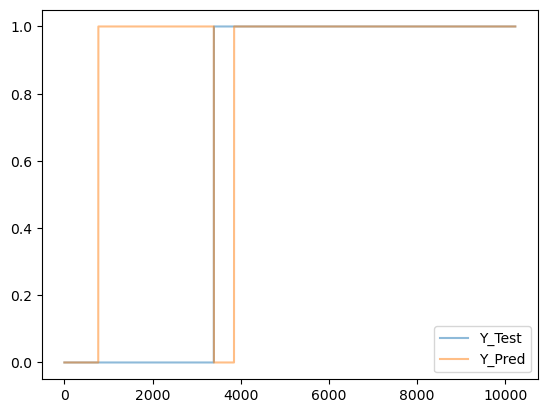

In [28]:
model = LogisticRegression(max_iter=10000)
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='LogReg'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# KNeighborsClassifier

Mean Error: 0.3340826898641384
Mean Squared Error: 0.3340826898641384
R-squared:  -0.5076698553618886
confusion:
[[1260 2131]
 [1287 5553]]


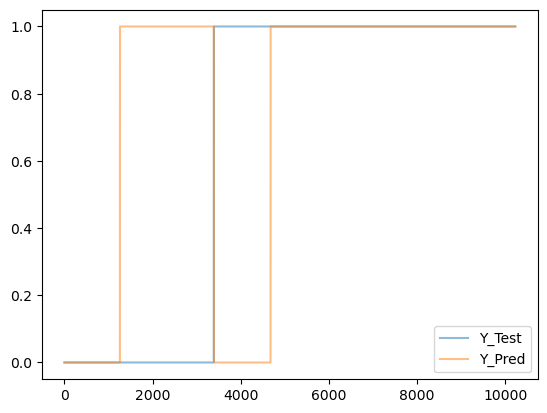

In [29]:
model = KNeighborsClassifier()
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='KNeighborsClassifier'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# XGBoost

Mean Error: 0.29048968820252175
Mean Squared Error: 0.29048968820252175
R-squared:  -0.310940552994597
confusion:
[[1018 2373]
 [ 599 6241]]


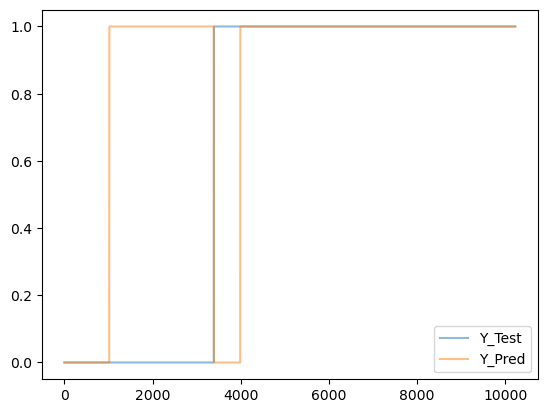

In [30]:
model = xgb.XGBClassifier(eval_metric ='logloss')
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='XGBClassifier'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# SGDClassifier

Mean Error: 0.33115042517837945
Mean Squared Error: 0.33115042517837945
R-squared:  -0.49443694264659976
confusion:
[[ 536 2855]
 [ 533 6307]]


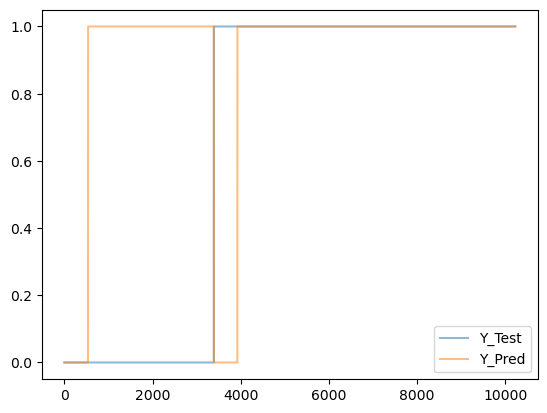

In [31]:
model = SGDClassifier(loss="modified_huber", penalty='l2',max_iter=10000)
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='SGDClassifier'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# GradientBoostingClassifier

Mean Error: 0.31072231453425864
Mean Squared Error: 0.31072231453425864
R-squared:  -0.4022476507300887
confusion:
[[ 339 3052]
 [ 127 6713]]


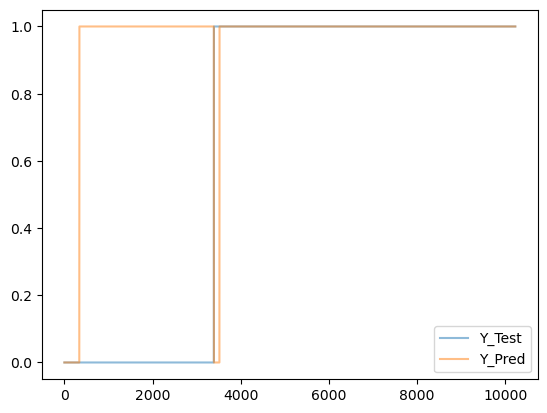

In [32]:
model = GradientBoostingClassifier(n_estimators=20)
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='GradientBoostingClassifier'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# AdaBoostClassifier

Mean Error: 0.3064216596618121
Mean Squared Error: 0.3064216596618121
R-squared:  -0.3828393787476654
confusion:
[[ 570 2821]
 [ 314 6526]]


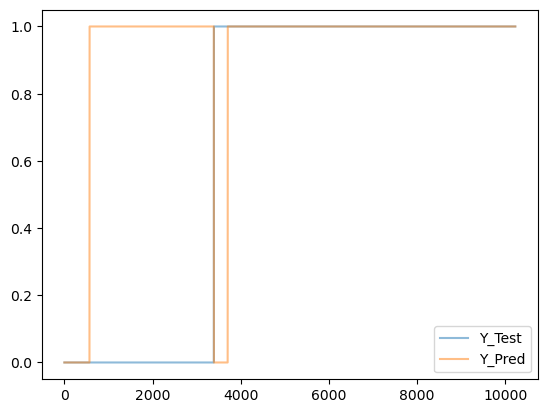

In [33]:
model = AdaBoostClassifier(n_estimators=20)
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='AdaBoostClassifier'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# RandomForestClassifier

Mean Error: 0.3376991496432411
Mean Squared Error: 0.3376991496432411
R-squared:  -0.5239904477107444
confusion:
[[1451 1940]
 [1515 5325]]


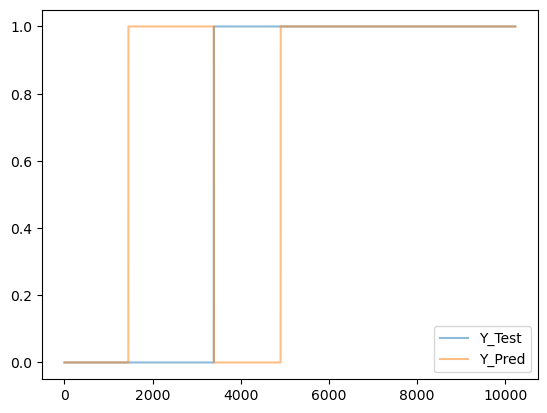

In [34]:
model = RandomForestClassifier(n_estimators = 20)
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='RandomForestClassifier'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# Arbol

Mean Error: 0.3138500635324015
Mean Squared Error: 0.3138500635324015
R-squared:  -0.41636275762639663
confusion:
[[ 659 2732]
 [ 479 6361]]


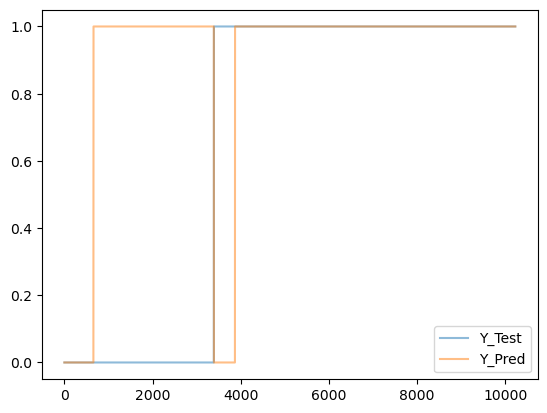

In [35]:
model = DecisionTreeClassifier(criterion='gini', max_depth=4)
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='DecisionTreeClassifier'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# GaussianNB

Mean Error: 0.6029713615482357
Mean Squared Error: 0.6029713615482357
R-squared:  -1.7211279513538589
confusion:
[[3230  161]
 [6008  832]]


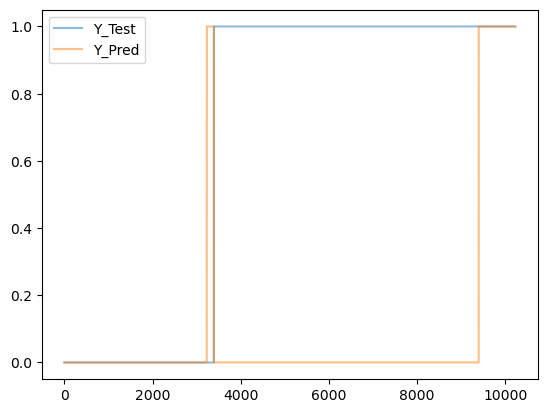

In [36]:
model = GaussianNB()
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='GaussianNB'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# Bernoulli

Mean Error: 0.3341804320203304
Mean Squared Error: 0.3341804320203304
R-squared:  -0.5081109524523981
confusion:
[[1516 1875]
 [1544 5296]]


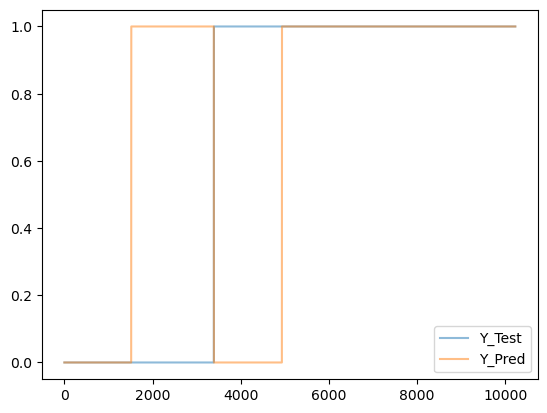

In [37]:
model = BernoulliNB()
model.fit(XTrain.values, YTrain.values.ravel())
# Use the model to make predictions on new data
Resultados=YTest.copy()
Resultados['Pred']=model.predict(XTest.values)
Resultados['Errores']=Resultados[ColumnaSelecta]-Resultados['Pred']
m = indicadores(Resultados[ColumnaSelecta],Resultados['Pred'])
Resultados=pd.DataFrame()
Modelo='BernoulliNB'
ResultadosparaModelos.loc[Modelo,'TN']=m[0,0]
ResultadosparaModelos.loc[Modelo,'TP']=m[1,1]
ResultadosparaModelos.loc[Modelo,'FP']=m[0,1]
ResultadosparaModelos.loc[Modelo,'FN']=m[1,0]

# A continuación se muestra tabla de resultados para los distintos modelos mostrados:

In [38]:
ResultadosparaModelos['Precision: TP/(FP+TP)']=ResultadosparaModelos['TP']/(ResultadosparaModelos['TP']+ResultadosparaModelos['FP'])
ResultadosparaModelos['Reccal: TP/(FN+TP)']=ResultadosparaModelos['TP']/(ResultadosparaModelos['TP']+ResultadosparaModelos['FN'])
ResultadosparaModelos['Accuracy: (TP+TN)/(TN+FN+TP+FP)']=(ResultadosparaModelos['TP']+ResultadosparaModelos['TN'])/(ResultadosparaModelos['TP']+ResultadosparaModelos['TN']+ResultadosparaModelos['FP']+ResultadosparaModelos['FN'])
ResultadosparaModelos['F1']=2*ResultadosparaModelos['Precision: TP/(FP+TP)']*ResultadosparaModelos['Reccal: TP/(FN+TP)']/(ResultadosparaModelos['Precision: TP/(FP+TP)']+ResultadosparaModelos['Reccal: TP/(FN+TP)'])
ResultadosparaModelos['Trues']=ResultadosparaModelos['TN']+ResultadosparaModelos['TP']
ResultadosparaModelos.sort_values(by=['Trues'],ascending=False)

,TN,TP,FP,FN,Precision: TP/(FP+TP),Reccal: TP/(FN+TP),Accuracy: (TP+TN)/(TN+FN+TP+FP),F1,Trues
XGBClassifier,1018.0,6241.0,2373.0,599.0,0.724518,0.912427,0.709510,0.807687,7259.0
LogReg,769.0,6382.0,2622.0,458.0,0.708796,0.933041,0.698954,0.805605,7151.0
AdaBoostClassifier,570.0,6526.0,2821.0,314.0,0.698192,0.954094,0.693578,0.806326,7096.0
GradientBoostingClassifier,339.0,6713.0,3052.0,127.0,0.687455,0.981433,0.689278,0.808552,7052.0
DecisionTreeClassifier,659.0,6361.0,2732.0,479.0,0.699549,0.929971,0.686150,0.798469,7020.0
SGDClassifier,536.0,6307.0,2855.0,533.0,0.688387,0.922076,0.668850,0.788276,6843.0
KNeighborsClassifier,1260.0,5553.0,2131.0,1287.0,0.722670,0.811842,0.665917,0.764665,6813.0
BernoulliNB,1516.0,5296.0,1875.0,1544.0,0.738530,0.774269,0.665820,0.755977,6812.0
RandomForestClassifier,1451.0,5325.0,1940.0,1515.0,0.732966,0.778509,0.662301,0.755051,6776.0
GaussianNB,3230.0,832.0,161.0,6008.0,0.837865,0.121637,0.397029,0.212435,4062.0
